<a href="https://www.kaggle.com/code/muradpitafi/global-disaster-intelligence-2018-2024-severity?scriptVersionId=282421078" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Global Disaster Response (2018–2024)
**Exploratory analysis, statistical tests, clustering, and predictive models**
Author: Murad Pitafi — Kaggle-ready, sectioned notebook
Dataset: `global_disaster_response_2018_2024 (1).csv` (50k rows)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-daset/global_disaster_response_2018_2024 (1).csv


# 1) Imports & settings (code cell)

In [2]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# ML & stats
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Explainability
import shap

# Utilities
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plot settings
sns.set(style='whitegrid', rc={'figure.figsize':(10,6)})


# 2) Load dataset & initial peek (code cell)

In [3]:
# Adjust file path if necessary
FILE = '/kaggle/input/global-daset/global_disaster_response_2018_2024 (1).csv'

df = pd.read_csv(FILE)
print("Shape:", df.shape)
display(df.head())
display(df.info())
display(df.describe(include='all').T)


Shape: (50000, 12)


,date,country,disaster_type,severity_index,casualties,economic_loss_usd,response_time_hours,aid_amount_usd,response_efficiency_score,recovery_days,latitude,longitude
0,2021-01-31,Brazil,Earthquake,5.99,111,7934365.71,15.62,271603.79,83.21,67,-30.613,-122.557
1,2018-12-23,Brazil,Extreme Heat,6.53,100,8307648.99,5.03,265873.81,96.18,55,10.859,-159.194
2,2020-08-10,India,Hurricane,1.55,22,765136.99,32.54,49356.49,60.40,22,0.643,-160.978
3,2022-09-15,Indonesia,Extreme Heat,4.55,94,1308251.31,7.83,237512.88,86.41,47,-33.547,30.350
4,2022-09-28,United States,Wildfire,3.80,64,2655864.36,21.90,188910.69,72.81,42,-19.170,-117.137


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       50000 non-null  object 
 1   country                    50000 non-null  object 
 2   disaster_type              50000 non-null  object 
 3   severity_index             50000 non-null  float64
 4   casualties                 50000 non-null  int64  
 5   economic_loss_usd          50000 non-null  float64
 6   response_time_hours        50000 non-null  float64
 7   aid_amount_usd             50000 non-null  float64
 8   response_efficiency_score  50000 non-null  float64
 9   recovery_days              50000 non-null  int64  
 10  latitude                   50000 non-null  float64
 11  longitude                  50000 non-null  float64
dtypes: float64(7), int64(2), object(3)
memory usage: 4.6+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,50000,2557,2023-08-29,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,50000,20,Brazil,2591,NaN,NaN,NaN,NaN,NaN,NaN,NaN
disaster_type,50000,10,Landslide,5130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
severity_index,50000.0,NaN,NaN,NaN,5.015769,1.942843,1.0,3.66,4.99,6.34,10.0
casualties,50000.0,NaN,NaN,NaN,100.59114,65.052064,0.0,51.0,91.0,138.0,524.0
economic_loss_usd,50000.0,NaN,NaN,NaN,5068593.448265,3268540.520971,527.39,2585513.4775,4548350.735,6950614.605,24456237.87
response_time_hours,50000.0,NaN,NaN,NaN,12.183027,9.259081,1.0,6.27,10.51,15.45,63.1
aid_amount_usd,50000.0,NaN,NaN,NaN,250000.329129,143227.514276,16.6,142966.335,230536.47,335225.93,1126465.23
response_efficiency_score,50000.0,NaN,NaN,NaN,87.574025,10.188961,29.75,83.06,89.18,94.7,100.0
recovery_days,50000.0,NaN,NaN,NaN,49.68256,20.098944,2.0,36.0,49.0,63.0,112.0


# 3) Quick data sanity checks & rename columns (code cell)

In [4]:
# Standardize column names (snake_case), fix obvious typos
df.columns = [c.strip().lower().replace(' ', '_').replace('(', '').replace(')', '') for c in df.columns]
df = df.rename(columns={
    'disaster_type':'disaster_type',
    'severity_index':'severity_index',
    'casualties':'casualties',
    'economic_loss_usd':'economic_loss_usd',
    'response_time_hours':'response_time_hours',
    'aid_amount_usd':'aid_amount_usd',
    'response_efficiency_score':'response_efficiency_score',
    'recovery_days':'recovery_days',
    'latitude':'latitude',
    'longitude':'longitude',
    'date':'date'
})

# Convert date
df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=False)
print("Missing dates:", df['date'].isna().sum())

# Basic missingness summary
missing = (df.isnull().sum() / len(df)).sort_values(ascending=False)
display(missing.head(20))


Missing dates: 0


date                         0.0
country                      0.0
disaster_type                0.0
severity_index               0.0
casualties                   0.0
economic_loss_usd            0.0
response_time_hours          0.0
aid_amount_usd               0.0
response_efficiency_score    0.0
recovery_days                0.0
latitude                     0.0
longitude                    0.0
dtype: float64

# 4) Feature engineering — temporal & simple derived features

In [5]:
# Extract temporal features
df['year']  = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['dayofweek'] = df['date'].dt.day_name()

# Create a vulnerability index (example)
# Avoid division by zero and NaNs
df['response_efficiency_score'] = pd.to_numeric(df['response_efficiency_score'], errors='coerce')
df['severity_index'] = pd.to_numeric(df['severity_index'], errors='coerce')
df['vulnerability_index'] = (df['severity_index'].fillna(0) * df['casualties'].fillna(0)) / (df['response_efficiency_score'].replace(0, np.nan).fillna(df['response_efficiency_score'].median()))
df['vulnerability_index'] = df['vulnerability_index'].replace([np.inf, -np.inf], np.nan)

display(df[['date','year','month','disaster_type','severity_index','casualties','response_efficiency_score','vulnerability_index']].head())


,date,year,month,disaster_type,severity_index,casualties,response_efficiency_score,vulnerability_index
0,2021-01-31,2021,1,Earthquake,5.99,111,83.21,7.990506
1,2018-12-23,2018,12,Extreme Heat,6.53,100,96.18,6.789353
2,2020-08-10,2020,8,Hurricane,1.55,22,60.40,0.564570
3,2022-09-15,2022,9,Extreme Heat,4.55,94,86.41,4.949659
4,2022-09-28,2022,9,Wildfire,3.80,64,72.81,3.340201


# 5) Cleaning & outlier handling

In [6]:
# Convert numeric columns
num_cols = ['severity_index','casualties','economic_loss_usd','response_time_hours','aid_amount_usd','response_efficiency_score','recovery_days','latitude','longitude']
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Remove impossible values (negatives where not allowed)
for c in ['casualties','economic_loss_usd','aid_amount_usd','recovery_days']:
    df.loc[df[c] < 0, c] = np.nan

# Cap extreme outliers at the 99.5 percentile (Winsorize-style)
for c in ['economic_loss_usd','aid_amount_usd','casualties']:
    if c in df.columns:
        upper = df[c].quantile(0.995)
        df[c] = np.where(df[c] > upper, upper, df[c])

# Drop rows without date or country (critical)
df = df.dropna(subset=['date','country'])
df.reset_index(drop=True, inplace=True)
print("After cleaning shape:", df.shape)


After cleaning shape: (50000, 17)


# 6) EDA — time series & counts

In [7]:
# Events per year
events_per_year = df.groupby('year').size().reset_index(name='count')
fig = px.bar(events_per_year, x='year', y='count', title='Disaster Events per Year (2018-2024)')
fig.show()

# Average severity by year
avg_sev = df.groupby('year')['severity_index'].mean().reset_index()
fig = px.line(avg_sev, x='year', y='severity_index', title='Average Severity Index per Year', markers=True)
fig.show()


# 7) EDA — top countries & disaster types

In [8]:
# Top countries by event count
top_countries = df['country'].value_counts().nlargest(15).reset_index()
top_countries.columns = ['country','count']
fig = px.bar(top_countries, x='count', y='country', orientation='h', title='Top 15 Countries by # of Events')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

# Disaster type breakdown
type_counts = df['disaster_type'].value_counts().reset_index()
type_counts.columns = ['disaster_type','count']
fig = px.pie(type_counts, values='count', names='disaster_type', title='Disaster Type Distribution')
fig.show()


# 8) Geographic visualization

In [9]:
# World scatter plot of events (sampling if too many points)
sample = df.sample(n=min(5000, len(df)), random_state=RANDOM_STATE)  # limit for plotting speed
fig = px.scatter_geo(sample, lat='latitude', lon='longitude', color='disaster_type',
                     hover_name='country', size='severity_index',
                     title='Geographic Distribution of Sampled Disaster Events')
fig.update_geos(projection_type="natural earth")
fig.show()


# 9) Correlations & heatmap

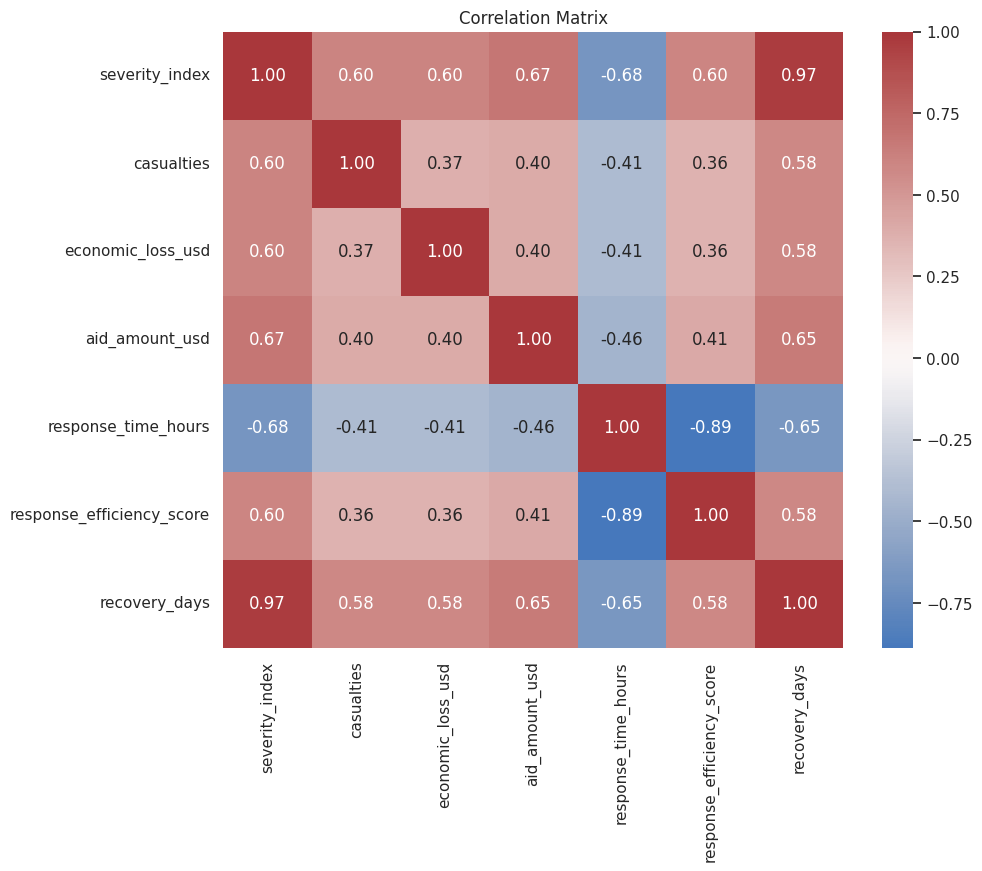

In [10]:
# Select numeric features for correlation
corr_cols = ['severity_index','casualties','economic_loss_usd','aid_amount_usd','response_time_hours','response_efficiency_score','recovery_days']
corr = df[corr_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=0)
plt.title('Correlation Matrix')
plt.show()


# 10) Hypothesis test & regression check

In [11]:
# H1: Faster response (lower response_time_hours) -> lower recovery_days
sub = df.dropna(subset=['response_time_hours','recovery_days'])
from scipy.stats import pearsonr
r, p = pearsonr(sub['response_time_hours'], sub['recovery_days'])
print(f'pearson r = {r:.3f}, p-value = {p:.3e}')

# Quick linear regression fit for visualization
import statsmodels.api as sm
X = sm.add_constant(sub['response_time_hours'])
model = sm.OLS(sub['recovery_days'], X, missing='drop').fit()
print(model.summary().tables[1])


pearson r = -0.654, p-value = 0.000e+00
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  66.9909      0.112    596.440      0.000      66.771      67.211
response_time_hours    -1.4207      0.007   -193.554      0.000      -1.435      -1.406


# 11) ML — Prepare dataset & pipelines

In [12]:
# We'll build two models:
#  - Predict recovery_days (regression)
#  - Predict response_efficiency_score (regression)

# Select features (keep it reasonable)
features = ['severity_index','casualties','economic_loss_usd','aid_amount_usd','response_time_hours','latitude','longitude','year']
target_recovery = 'recovery_days'
target_eff = 'response_efficiency_score'

df_ml = df[features + [target_recovery, target_eff]].copy()

# Drop rows where target is missing for respective models when training
df_recovery = df_ml.dropna(subset=[target_recovery]).copy()
df_eff = df_ml.dropna(subset=[target_eff]).copy()

# Simple numeric pipeline
numeric_features = ['severity_index','casualties','economic_loss_usd','aid_amount_usd','response_time_hours','latitude','longitude','year']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
])


# 12) ML model — Recovery days (Random Forest + XGBoost)

In [13]:
# Split
X = df_recovery[numeric_features]
y = df_recovery[target_recovery]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Pipeline + RandomForest
rf_pipe = Pipeline(steps=[('preproc', preprocessor),
                          ('model', RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1))])
rf_pipe.fit(X_train, y_train)
pred = rf_pipe.predict(X_test)
print("RF Recovery - RMSE:", mean_squared_error(y_test, pred, squared=False), "R2:", r2_score(y_test, pred))

# XGBoost
xgb_pipe = Pipeline(steps=[('preproc', preprocessor),
                           ('model', xgb.XGBRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=4))])
xgb_pipe.fit(X_train, y_train)
pred_x = xgb_pipe.predict(X_test)
print("XGB Recovery - RMSE:", mean_squared_error(y_test, pred_x, squared=False), "R2:", r2_score(y_test, pred_x))


RF Recovery - RMSE: 5.103467953999516 R2: 0.9358465560433228
XGB Recovery - RMSE: 5.2443567799502135 R2: 0.9322555609986252


# 13) Feature importance + SHAP for Recovery model

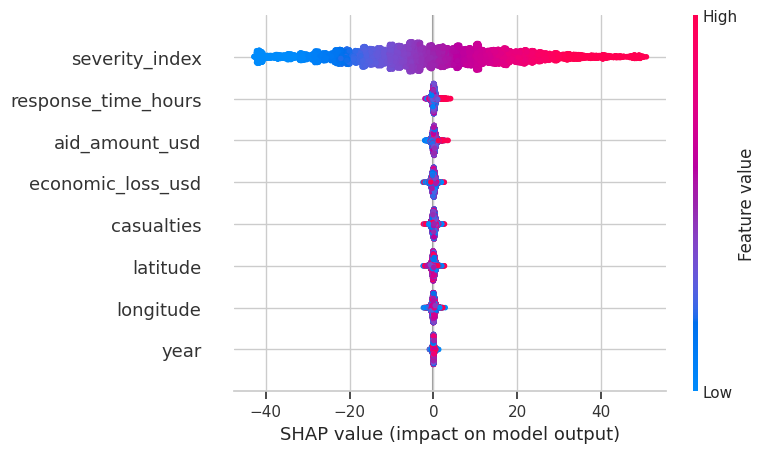

In [14]:
# Use the XGBoost model's internal booster for SHAP
# Extract transformed features for SHAP: get numeric transformer fitted on training data
prep = preprocessor.named_transformers_['num']
X_train_trans = prep.transform(X_train)
X_test_trans = prep.transform(X_test)

# Fit a simple XGBoost on numeric transformed arrays (to use shap easily)
xgb_simple = xgb.XGBRegressor(n_estimators=200, random_state=RANDOM_STATE)
xgb_simple.fit(X_train_trans, y_train)

# SHAP explainer
explainer = shap.Explainer(xgb_simple)
shap_values = explainer(X_test_trans)

# Summary plot
shap.summary_plot(shap_values, features=X_test_trans, feature_names=numeric_features, show=True)


# 15) Clustering — KMeans to find event archetypes

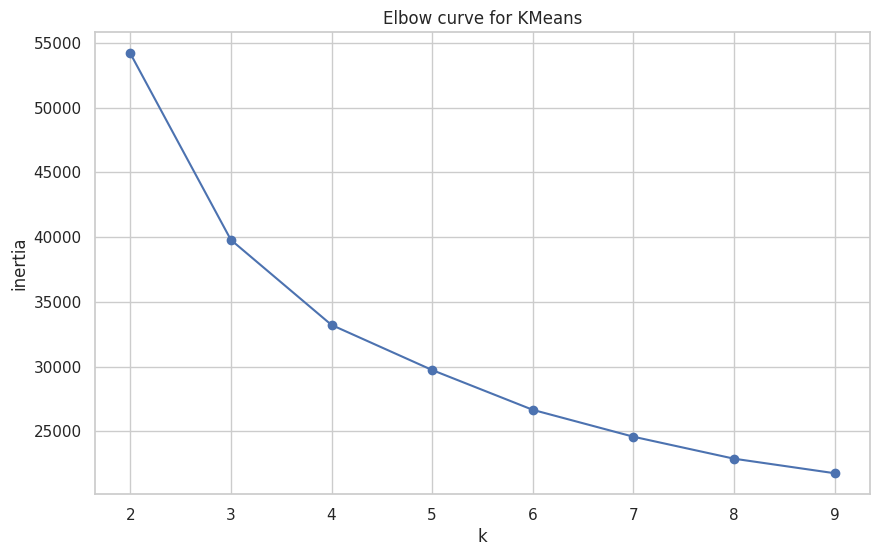

cluster,0,1,2,3
severity_index,5.282657e+00,1.333173e+00,3.300294e+00,7.368269e+00
casualties,9.669813e+01,2.640745e+01,6.112776e+01,1.713410e+02
economic_loss_usd,4.928933e+06,1.320371e+06,3.088057e+06,8.433497e+06
response_time_hours,8.650148e+00,4.038594e+01,1.659482e+01,6.842605e+00
recovery_days,5.243980e+01,1.258534e+01,3.208995e+01,7.373757e+01
response_efficiency_score,9.150651e+01,5.905495e+01,8.293794e+01,9.276034e+01


In [15]:
# Use a few normalized numeric features for clustering
cluster_cols = ['severity_index','casualties','economic_loss_usd','response_time_hours','recovery_days','response_efficiency_score']
cl_df = df[cluster_cols].dropna().sample(n=min(15000, df.shape[0]), random_state=RANDOM_STATE)  # sample for speed
scaler = StandardScaler()
Xc = scaler.fit_transform(cl_df)

# Find elbow
inertias = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    km.fit(Xc)
    inertias.append(km.inertia_)

plt.plot(K, inertias, '-o')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Elbow curve for KMeans')
plt.show()

# Fit with chosen k (e.g., 4)
k = 4
km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20)
labels = km.fit_predict(Xc)
clust_df = cl_df.copy()
clust_df['cluster'] = labels

# Basic cluster profiling
profile = clust_df.groupby('cluster').mean().T
display(profile)


# 16) Cluster visualization (PCA 2D)

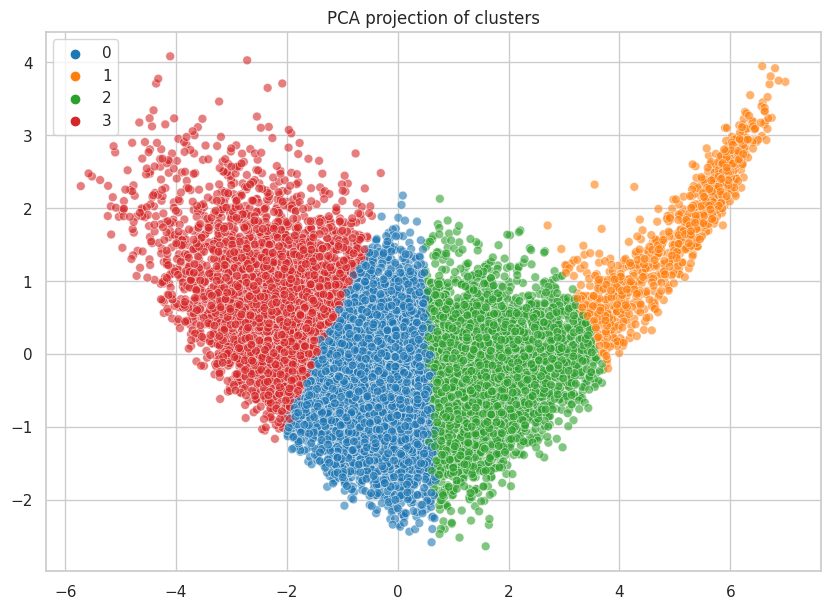

In [16]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
pc = pca.fit_transform(Xc)
plt.figure(figsize=(10,7))
sns.scatterplot(x=pc[:,0], y=pc[:,1], hue=labels, palette='tab10', alpha=0.6, s=40)
plt.title('PCA projection of clusters')
plt.show()


# 17) Business insights & final summary

In [17]:
# Key-takeaways code cell
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

RANDOM_STATE = 42

# 0. Basic safety: ensure df exists
try:
    df
except NameError:
    raise RuntimeError("DataFrame `df` not found. Run your data-loading cell first.")

# 1) Top 5 countries by event frequency
top5 = df['country'].value_counts().nlargest(5)
print("Top 5 countries by event frequency:")
print(top5)
print("\n")

# 2) Pearson correlation between response_time_hours and recovery_days
corr_df = df[['response_time_hours','recovery_days']].dropna()
if len(corr_df) < 10:
    print("Not enough data for correlation (need >=10 rows).")
else:
    r, p = pearsonr(corr_df['response_time_hours'], corr_df['recovery_days'])
    print(f"Pearson correlation between response_time_hours and recovery_days: r = {r:.3f}, p = {p:.3e}")
    if p < 0.05:
        print(" -> Statistically significant correlation (p < 0.05).")
    else:
        print(" -> Not statistically significant (p >= 0.05).")
print("\n")

# 3) Train simple RF and XGBoost to get feature importances for recovery prediction
# Select numeric features (adjust if you renamed columns)
features = ['severity_index','casualties','economic_loss_usd','aid_amount_usd','response_time_hours','response_efficiency_score','latitude','longitude','year']
available_feats = [c for c in features if c in df.columns]

df_ml = df[available_feats + ['recovery_days']].copy().dropna(subset=['recovery_days'])
df_ml = df_ml.dropna(subset=available_feats)  # drop rows with missing features for simplicity

if df_ml.shape[0] < 50:
    print("Not enough rows to train models for feature importances (need >=50 rows).")
else:
    X = df_ml[available_feats].astype(float)
    y = df_ml['recovery_days'].astype(float)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

    # Random Forest
    rf = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
    rf.fit(X_train, y_train)
    rf_imps = pd.Series(rf.feature_importances_, index=available_feats).sort_values(ascending=False)

    # XGBoost (simple)
    xg = xgb.XGBRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=4, verbosity=0)
    xg.fit(X_train, y_train)
    xg_imps = pd.Series(xg.feature_importances_, index=available_feats).sort_values(ascending=False)

    print("Top feature importances (Random Forest):")
    print(rf_imps.head(10).to_string())
    print("\nTop feature importances (XGBoost):")
    print(xg_imps.head(10).to_string())
print("\n")

# 4) KMeans clustering and cluster archetypes
cluster_cols = ['severity_index','casualties','economic_loss_usd','response_time_hours','recovery_days','response_efficiency_score']
cluster_cols = [c for c in cluster_cols if c in df.columns]

cl_df = df[cluster_cols].dropna().copy()
n_samples = min(15000, len(cl_df))
if n_samples < 50:
    print("Not enough data for clustering (need >=50 rows).")
else:
    cl_sample = cl_df.sample(n=n_samples, random_state=RANDOM_STATE)
    scaler = StandardScaler()
    Xc = scaler.fit_transform(cl_sample)

    k = 4
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20)
    labels = km.fit_predict(Xc)
    cl_sample = cl_sample.reset_index(drop=True)
    cl_sample['cluster'] = labels

    # Cluster profile (mean values in original scale)
    profile = cl_sample.groupby('cluster').mean().T
    print("Cluster profile (mean values):")
    display(profile)

    # Create descriptive archetype names based on a few key metrics
    # We'll base names on severity_index, recovery_days, response_efficiency_score
    cluster_summary = cl_sample.groupby('cluster').agg({
        'severity_index':'mean',
        'recovery_days':'mean',
        'response_efficiency_score':'mean',
        'casualties':'mean',
        'economic_loss_usd':'mean'
    }).round(2)

    archetypes = {}
    for idx, row in cluster_summary.iterrows():
        sev = row['severity_index']
        rec = row['recovery_days']
        eff = row['response_efficiency_score']
        # Simple heuristics for naming
        if sev >= cl_sample['severity_index'].quantile(0.66) and rec >= cl_sample['recovery_days'].quantile(0.66):
            name = "High severity & Long recovery"
        elif sev >= cl_sample['severity_index'].quantile(0.66) and eff >= cl_sample['response_efficiency_score'].quantile(0.66):
            name = "High severity & Good response efficiency"
        elif sev <= cl_sample['severity_index'].quantile(0.33) and eff >= cl_sample['response_efficiency_score'].quantile(0.66):
            name = "Low severity & Fast recovery"
        else:
            name = "Moderate / Mixed profile"
        archetypes[idx] = name

    print("\nCluster summary (means):")
    display(cluster_summary)
    print("Assigned archetype names:")
    for c, name in archetypes.items():
        print(f" - Cluster {c}: {name}")
print("\n")

# 5) Suggested actions (printed as plain recommendations)
print("Suggested actions (based on above analyses):")
print("1) Prioritize pre-positioned aid in countries that appear in the top frequency list and show high vulnerability_index.")
print("2) Invest in rapid response capabilities where response_time_hours correlates with longer recovery_days (see correlation result).")
print("3) Focus training/equipment for clusters labeled 'High severity & Long recovery' to reduce recovery time and casualties.")
print("4) Investigate events classified as outliers (very high economic_loss_usd or casualties) for targeted policy lessons.")
print("5) Use the trained models and feature importance rankings to guide which operational metrics (severity, casualties, economic loss) are most predictive of long recovery and invest accordingly.")


Top 5 countries by event frequency:
country
Brazil        2591
Australia     2563
Turkey        2554
Bangladesh    2553
Spain         2543
Name: count, dtype: int64


Pearson correlation between response_time_hours and recovery_days: r = -0.654, p = 0.000e+00
 -> Statistically significant correlation (p < 0.05).


Top feature importances (Random Forest):
severity_index               0.942980
longitude                    0.008162
latitude                     0.008069
aid_amount_usd               0.008038
economic_loss_usd            0.007974
casualties                   0.007366
response_time_hours          0.007181
response_efficiency_score    0.007059
year                         0.003170

Top feature importances (XGBoost):
severity_index               0.965480
response_time_hours          0.004550
response_efficiency_score    0.004453
latitude                     0.004450
longitude                    0.004435
aid_amount_usd               0.004282
economic_loss_usd            0.004269

cluster,0,1,2,3
severity_index,5.282657e+00,1.333173e+00,3.300294e+00,7.368269e+00
casualties,9.669813e+01,2.640745e+01,6.112776e+01,1.713410e+02
economic_loss_usd,4.928933e+06,1.320371e+06,3.088057e+06,8.433497e+06
response_time_hours,8.650148e+00,4.038594e+01,1.659482e+01,6.842605e+00
recovery_days,5.243980e+01,1.258534e+01,3.208995e+01,7.373757e+01
response_efficiency_score,9.150651e+01,5.905495e+01,8.293794e+01,9.276034e+01



Cluster summary (means):


,severity_index,recovery_days,response_efficiency_score,casualties,economic_loss_usd
cluster,,,,,
0,5.28,52.44,91.51,96.70,4928932.70
1,1.33,12.59,59.05,26.41,1320371.17
2,3.30,32.09,82.94,61.13,3088056.69
3,7.37,73.74,92.76,171.34,8433497.19


Assigned archetype names:
 - Cluster 0: Moderate / Mixed profile
 - Cluster 1: Moderate / Mixed profile
 - Cluster 2: Moderate / Mixed profile
 - Cluster 3: High severity & Long recovery


Suggested actions (based on above analyses):
1) Prioritize pre-positioned aid in countries that appear in the top frequency list and show high vulnerability_index.
2) Invest in rapid response capabilities where response_time_hours correlates with longer recovery_days (see correlation result).
3) Focus training/equipment for clusters labeled 'High severity & Long recovery' to reduce recovery time and casualties.
4) Investigate events classified as outliers (very high economic_loss_usd or casualties) for targeted policy lessons.
5) Use the trained models and feature importance rankings to guide which operational metrics (severity, casualties, economic loss) are most predictive of long recovery and invest accordingly.


# 18) Appendix — reproducibility & runtime tips

- Use Kaggle GPU only if training really large XGBoost; CPU is fine for these runs.
- Save models with joblib or pickle.
- Add meaningful captions under each chart for judges and readers.
- Keep cells short and comment liberally — reviewers love interpretation after every visualization.
